# Decision Trees

This code is written as part of an assignment to build a decision tree. The decision tree is then used to classify the three MONK datasets provided by [UC Irvine](https://archive.ics.uci.edu/ml/datasets/MONK's+Problems "MONK's problems"). The tree is also pruned to counteract overfitting. 

These are the properties of the MONK dataset:
![MONK properties](assets/properties.jpg "Properties of the MONK datasets")

The three different MONK datasets is built on the following concepts:
![MONK Concepts](assets/concepts.jpg "Concepts of the MONK datasets")

The MONK datasets and their corresponding attributes are stored in the monkdata file. The functions used are found in the dtree file, some of these were given as part of the assignment.


## Calculating Entropy
The entropy is calculated to see how much uncertainty there is in each dataset. Keep in mind the output of the dataset is binary so entropy 1.0 means maximum uncertainty. 

In [1]:
import monkdata as m
import dtree as d
import drawtree_qt5 as draw
import matplotlib.pyplot as plt
import numpy as np

monksTraining = [m.monk1, m.monk2, m.monk3]
monksTesting = [m.monk1test, m.monk2test, m.monk3test]

for i, dataset in enumerate(monksTraining):
    print("Entropy for MONK", i+1, " is: ", d.entropy(dataset))


Entropy for MONK 1  is:  1.0
Entropy for MONK 2  is:  0.957117428264771
Entropy for MONK 3  is:  0.9998061328047111


## Calculating Information gain
In the table below you can get a better view over all the information gained through the various attributes.

In [2]:
"""
These imports are done to display a table of the information gained by each attribute
If you would rather just see the score for each iteration you can uncomment the commented lines further below.
"""

from IPython.display import HTML, display
import tabulate

monkBestIndex = np.zeros(len(monksTraining))
monkBestScore = np.zeros(len(monksTraining))

#These variables are just for the table further down
headers = ["Datasets"]
table = np.empty([len(monksTraining),len(m.attributes)])
rowIDs = []
for i in range(len(monksTraining)):
    tableRow = "MONK" + str(i+1)
    rowIDs.append(tableRow)

for i, attr in enumerate(m.attributes):
    headers.append(attr)
    for monkIndex, monk in enumerate(monksTraining):
        table[monkIndex][i] = d.averageGain(monk, attr)
        if(d.averageGain(monk, attr)>monkBestScore[monkIndex]):
            monkBestScore[monkIndex] = d.averageGain(monk, attr)
            monkBestIndex[monkIndex] = i

display(HTML(tabulate.tabulate(table,headers, tablefmt='html', numalign="center", showindex=rowIDs)))

for i in range(len(monksTraining)):
    print("Most information gained for MONK", i+1, " by attribute ",
          monkBestIndex[i] + 1, " with information gain:", monkBestScore[i])

Datasets,A1,A2,A3,A4,A5,A6
MONK1,0.0752726,0.00583843,0.00470757,0.0263117,0.287031,0.000757856
MONK2,0.00375618,0.0024585,0.00105615,0.0156642,0.0172772,0.00624762
MONK3,0.00712087,0.293736,0.000831114,0.00289182,0.255912,0.00707703


Most information gained for MONK 1  by attribute  5.0  with information gain: 0.28703074971578435
Most information gained for MONK 2  by attribute  5.0  with information gain: 0.01727717693791797
Most information gained for MONK 3  by attribute  2.0  with information gain: 0.29373617350838865


## Building and testing the trees

In [3]:
monk1Tree = d.buildTree(m.monk1, m.attributes)
monk2Tree = d.buildTree(m.monk2, m.attributes)
monk3Tree = d.buildTree(m.monk3, m.attributes)

monkTrees = []
for monk in monksTraining:
    monkTrees.append(d.buildTree(monk, m.attributes))

#These built tress can be visualized by uncommenting one of the rows below

#draw.drawTree(monk1Tree)
#draw.drawTree(monk2Tree)
#draw.drawTree(monk3Tree)

unprunedError = np.zeros(len(monkTrees))

for i, tree in enumerate(monkTrees):
    unprunedError[i] = 1 - d.check(tree, monksTesting[i])
    print("MONK",i+1, " decision tree error on testing data:", unprunedError[i])

MONK 1  decision tree error on testing data: 0.17129629629629628
MONK 2  decision tree error on testing data: 0.30787037037037035
MONK 3  decision tree error on testing data: 0.05555555555555558


## Pruning the trees
Here we cut off unnecessary parts of the trees as they overfit the tree to the data. A tree is only pruned as long as it improves the accuracy. In order to prune efficiently the training data is partitioned into a part where training on the data is still done and a part where validation and pruning is done.

In [4]:
#These variables can be changed to make different tests.
numberOfTests = 100
partitionPercentages = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

monksPruned = np.empty([len(monksTraining),len(partitionPercentages)])

for i, percentage in enumerate(partitionPercentages):
    for j, monk in enumerate(monksTraining):        
        score = 0
        for avg in range(numberOfTests):
            trainSet, valSet = d.partition(monk, percentage)
            testTree = d.buildTree(trainSet, m.attributes)
            prunedTree = d.prune(testTree, valSet)
            score += d.check(prunedTree, monksTesting[j])
        score = score/numberOfTests
        error = 1 - score
        monksPruned[j][i] = error

for i in range(len(monksTraining)):
    print()
    print("Mean of the pruned tree for monk", i + 1, " (all partitions):", np.sum(monksPruned[i])/len(partitionPercentages))
    indexMin = np.argmin(monksPruned[i])
    print("Lowest error for monk", i + 1 ,"found with partitionpercentage", partitionPercentages[indexMin])
    print("The error for this percentage was:", monksPruned[i][indexMin])
        
display(HTML(tabulate.tabulate(monksPruned,partitionPercentages, tablefmt='html', numalign="center", showindex=rowIDs)))        


Mean of the pruned tree for monk 1  (all partitions): 0.21356095679012332
Lowest error for monk 1 found with partitionpercentage 0.7
The error for this percentage was: 0.19925925925925891

Mean of the pruned tree for monk 2  (all partitions): 0.33594907407407376
Lowest error for monk 2 found with partitionpercentage 0.5
The error for this percentage was: 0.3327777777777774

Mean of the pruned tree for monk 3  (all partitions): 0.04883487654320925
Lowest error for monk 3 found with partitionpercentage 0.7
The error for this percentage was: 0.03268518518518415


,0.3,0.4,0.5,0.6,0.7,0.8
MONK1,0.236921,0.213796,0.203727,0.202894,0.199259,0.224769
MONK2,0.33537,0.335532,0.332778,0.334861,0.338079,0.339074
MONK3,0.0809259,0.0583333,0.0434259,0.0380093,0.0326852,0.0396296


### Plotting the pruned trees

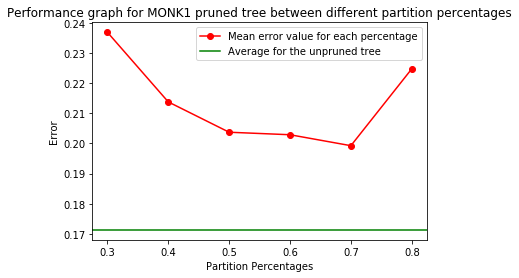

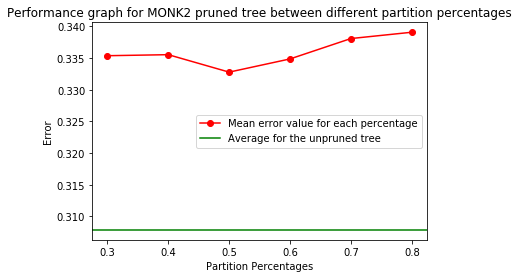

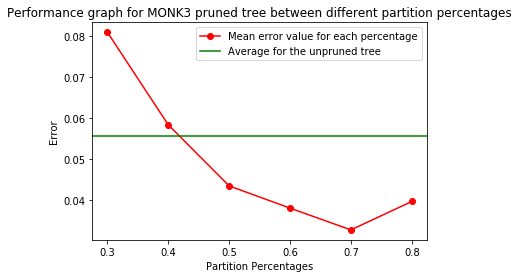

In [5]:
for i in range(len(monksTraining)):
    plt.plot(partitionPercentages, monksPruned[i], color='r', marker='o', label="Mean error value for each percentage")
    plt.axhline(y=unprunedError[i], color='g', linestyle='-', label="Average for the unpruned tree")
    plt.xlabel("Partition Percentages")
    plt.ylabel("Error")
    plt.title("Performance graph for MONK" + str(i+1) + " pruned tree between different partition percentages")
    plt.legend()
    plt.show()

#### Reflections
Notice how pruning does worse here than not pruning unless for the MONK3 datacase. MONK3 does better because it contains noise that's cut out when pruning. The other datasets does worse when pruning because their training data gets smaller when partitioning (it was already fairly small). Bigger training size when partitioning does not necessarely mean it's better as pruning still is great at solving overfitting (also consider the randomness involved in partitioning). 